# import required libraries 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog, local_binary_pattern
from skimage.filters import gabor
from scipy.stats import skew, kurtosis
import warnings
warnings.filterwarnings('ignore')
sns.set()
plt.style.use('ggplot')
%matplotlib inline
import os
warnings.filterwarnings('ignore')

## Dataset Description

### Dataset Source: https://www.kaggle.com/datasets/uciml/indian-liver-patient-records 

The dataset comprises detailed medical imaging data and associated clinical information from Indian patients, specifically gathered for research and development in the field of liver tumor segmentation.

In [2]:
# open csv file
df = pd.read_csv("liver_tumor_segmentation.csv")
df.columns = df.columns.map(str.lower)                              # column names to lowercase
df.head()

,age,gender,total_bilirubin,direct_bilirubin,alkaline_phosphotase,alamine_aminotransferase,aspartate_aminotransferase,total_protiens,albumin,albumin_and_globulin_ratio,dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


In [3]:
# check data types, it provides also details on null values, so next checking of null values may not be required
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         583 non-null    int64  
 1   gender                      583 non-null    object 
 2   total_bilirubin             583 non-null    float64
 3   direct_bilirubin            583 non-null    float64
 4   alkaline_phosphotase        583 non-null    int64  
 5   alamine_aminotransferase    583 non-null    int64  
 6   aspartate_aminotransferase  583 non-null    int64  
 7   total_protiens              583 non-null    float64
 8   albumin                     583 non-null    float64
 9   albumin_and_globulin_ratio  579 non-null    float64
 10  dataset                     583 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB


In [4]:
df.shape

(583, 11)

In [5]:
df.columns

Index(['age', 'gender', 'total_bilirubin', 'direct_bilirubin',
       'alkaline_phosphotase', 'alamine_aminotransferase',
       'aspartate_aminotransferase', 'total_protiens', 'albumin',
       'albumin_and_globulin_ratio', 'dataset'],
      dtype='object')

In [6]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,583.0,NaN,NaN,NaN,44.746141,16.189833,4.0,33.0,45.0,58.0,90.0
gender,583,2,Male,441,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_bilirubin,583.0,NaN,NaN,NaN,3.298799,6.209522,0.4,0.8,1.0,2.6,75.0
direct_bilirubin,583.0,NaN,NaN,NaN,1.486106,2.808498,0.1,0.2,0.3,1.3,19.7
alkaline_phosphotase,583.0,NaN,NaN,NaN,290.576329,242.937989,63.0,175.5,208.0,298.0,2110.0
alamine_aminotransferase,583.0,NaN,NaN,NaN,80.713551,182.620356,10.0,23.0,35.0,60.5,2000.0
aspartate_aminotransferase,583.0,NaN,NaN,NaN,109.910806,288.918529,10.0,25.0,42.0,87.0,4929.0
total_protiens,583.0,NaN,NaN,NaN,6.48319,1.085451,2.7,5.8,6.6,7.2,9.6
albumin,583.0,NaN,NaN,NaN,3.141852,0.795519,0.9,2.6,3.1,3.8,5.5
albumin_and_globulin_ratio,579.0,NaN,NaN,NaN,0.947064,0.319592,0.3,0.7,0.93,1.1,2.8


In [7]:
df.dtypes[df.dtypes=='object']

gender    object
dtype: object

### What can we see from describe & info ?
- for gender we have 2 unique values - sounds reasonable
- there seems to be extremes for several fields (compare 75% with max) - we will have to fix it
- dataset, our target variable, has 2 values
- albumin_and_globulin_ratio have some missing values those must be handled

## Data Cleaning

### Handle missing values
We are going to fix missing values on albumin_and_globulin_ratio field, easiest way is often best way, so just replace it with mean or median

In [8]:
print("Missing Values")
df.isnull().sum()

Missing Values


age                           0
gender                        0
total_bilirubin               0
direct_bilirubin              0
alkaline_phosphotase          0
alamine_aminotransferase      0
aspartate_aminotransferase    0
total_protiens                0
albumin                       0
albumin_and_globulin_ratio    4
dataset                       0
dtype: int64

In [9]:
# replacing missing values with mean
df.albumin_and_globulin_ratio.fillna(df.albumin_and_globulin_ratio.mean(), inplace=True)

In [10]:
# are there still any missing values?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         583 non-null    int64  
 1   gender                      583 non-null    object 
 2   total_bilirubin             583 non-null    float64
 3   direct_bilirubin            583 non-null    float64
 4   alkaline_phosphotase        583 non-null    int64  
 5   alamine_aminotransferase    583 non-null    int64  
 6   aspartate_aminotransferase  583 non-null    int64  
 7   total_protiens              583 non-null    float64
 8   albumin                     583 non-null    float64
 9   albumin_and_globulin_ratio  583 non-null    float64
 10  dataset                     583 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB


## Let's start exploratory data analysis (EDA)
Most datascientist will tell you that EDA is most funny part of datascience work. You are exploring different relations between data and how they interact... so do it!

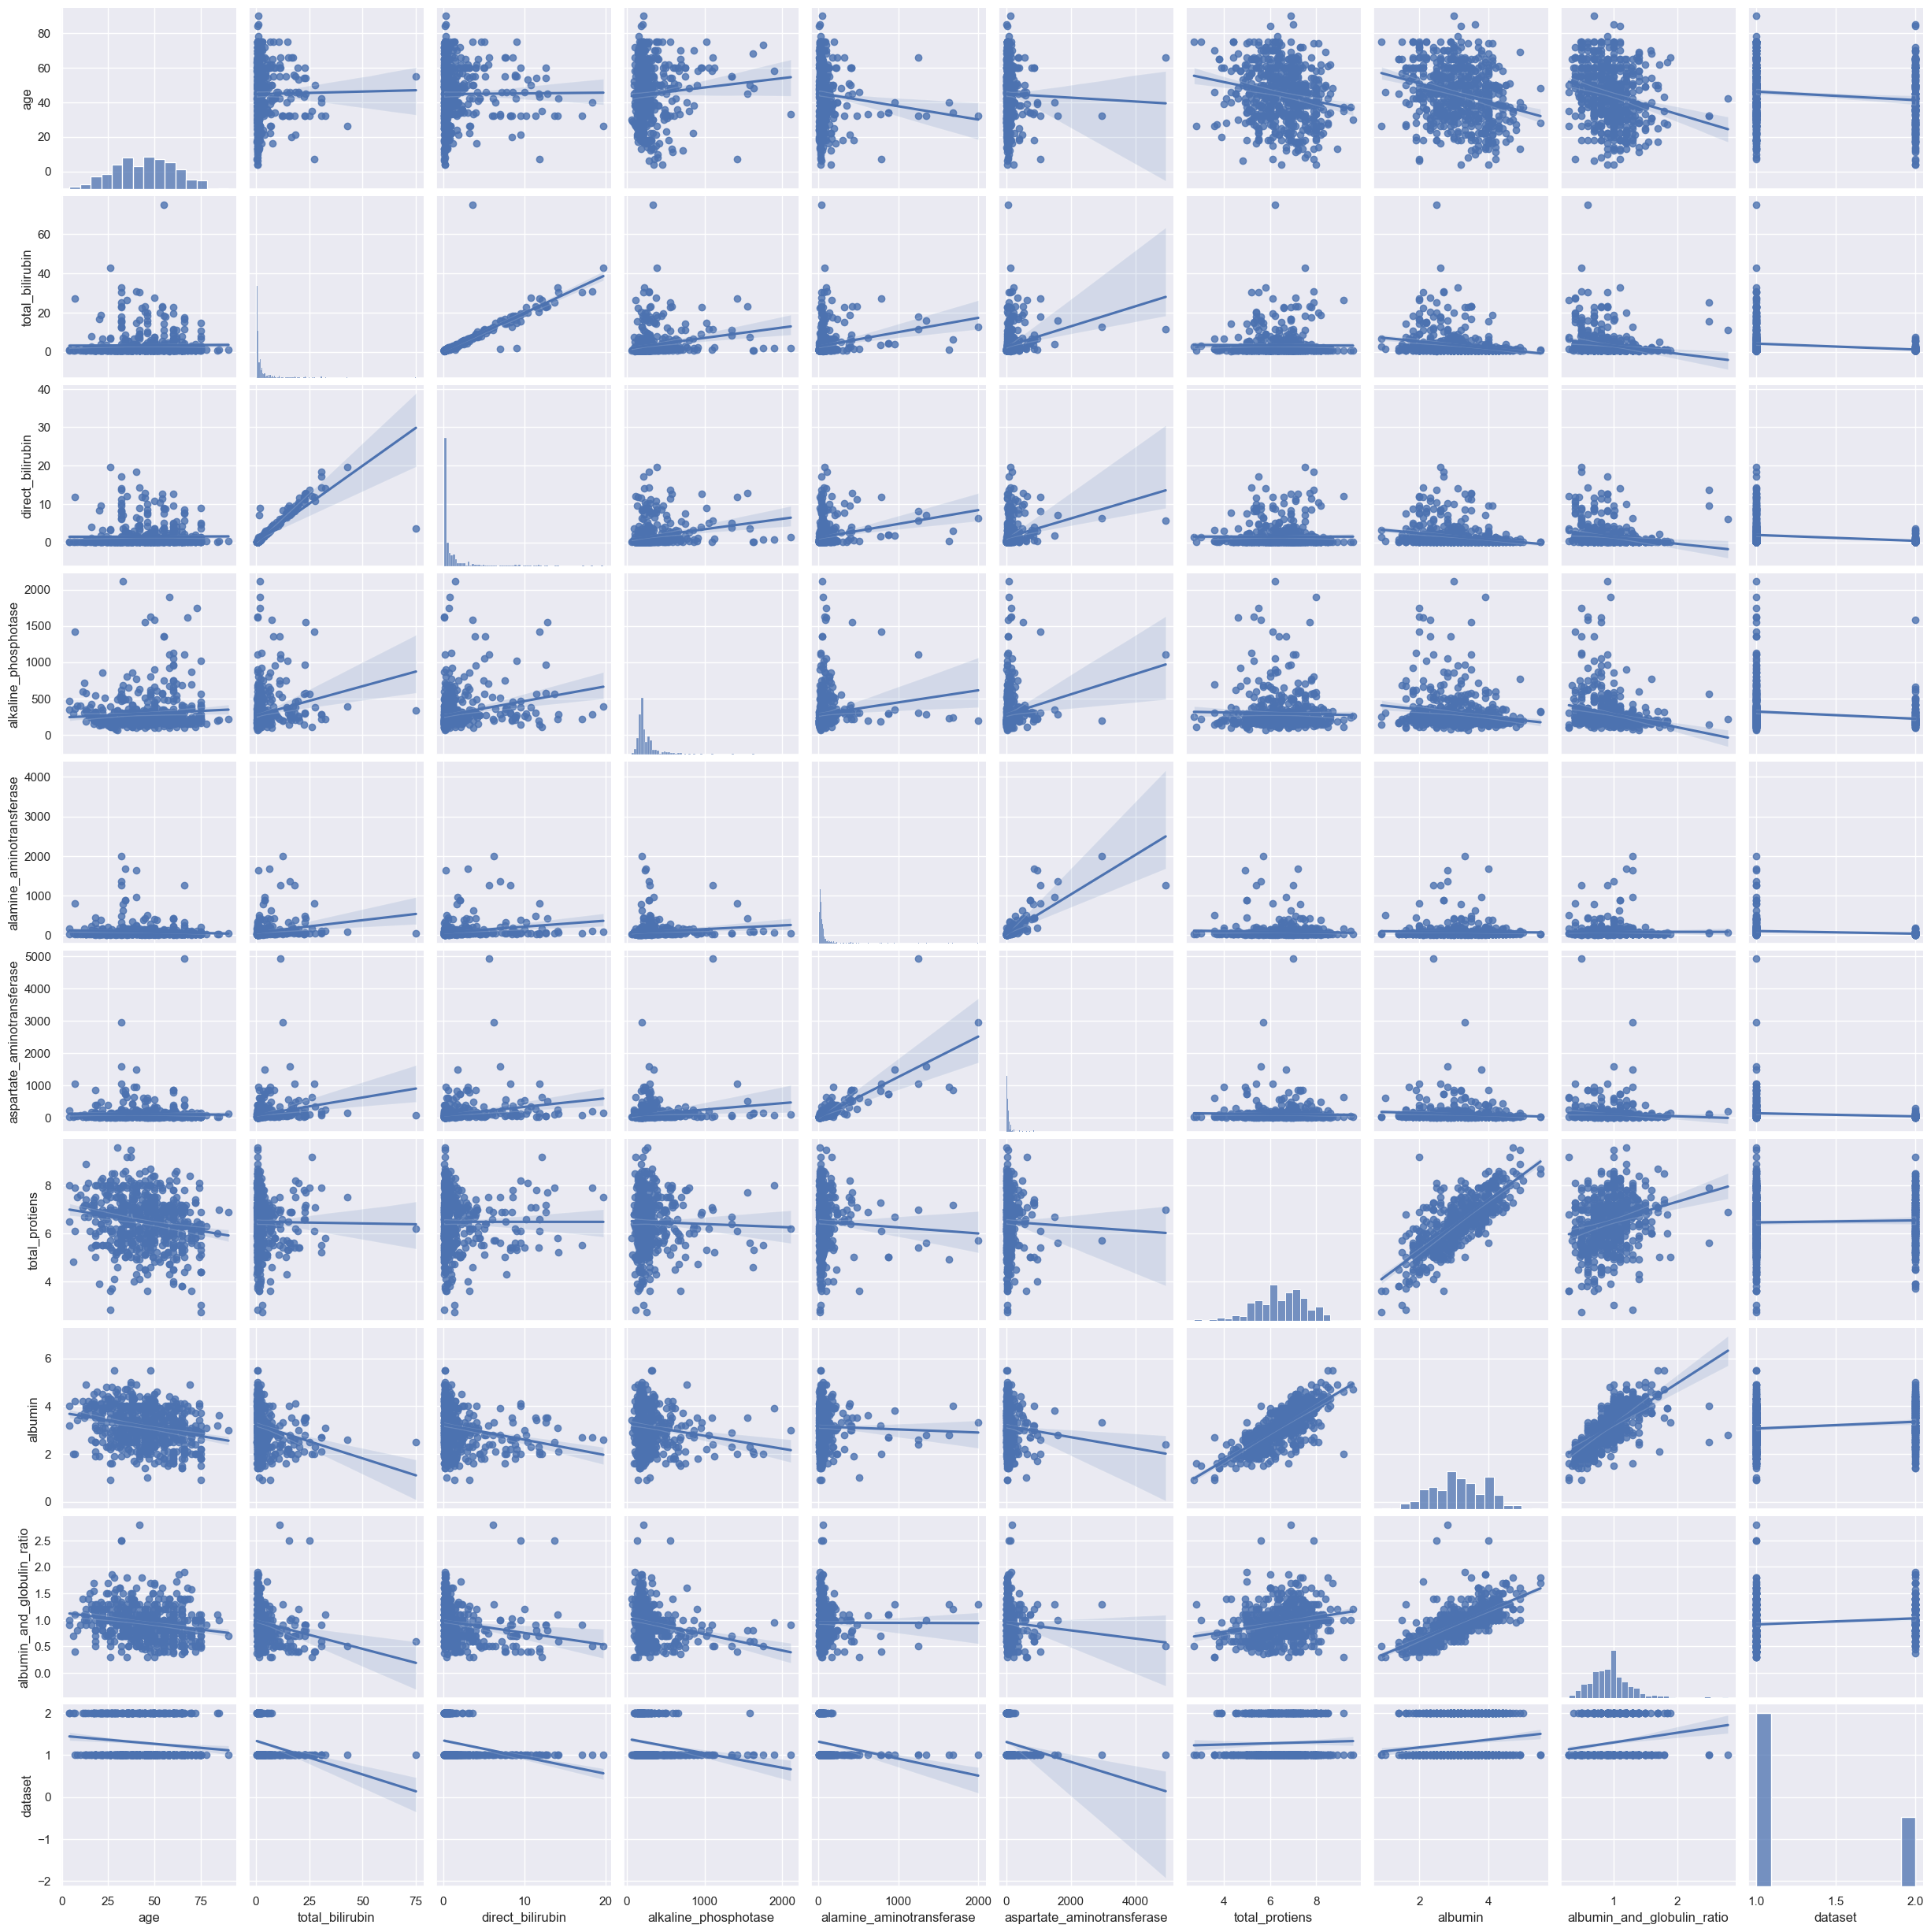

In [11]:
# correlation between variables
sns.set()
sns.pairplot(df, kind='reg')

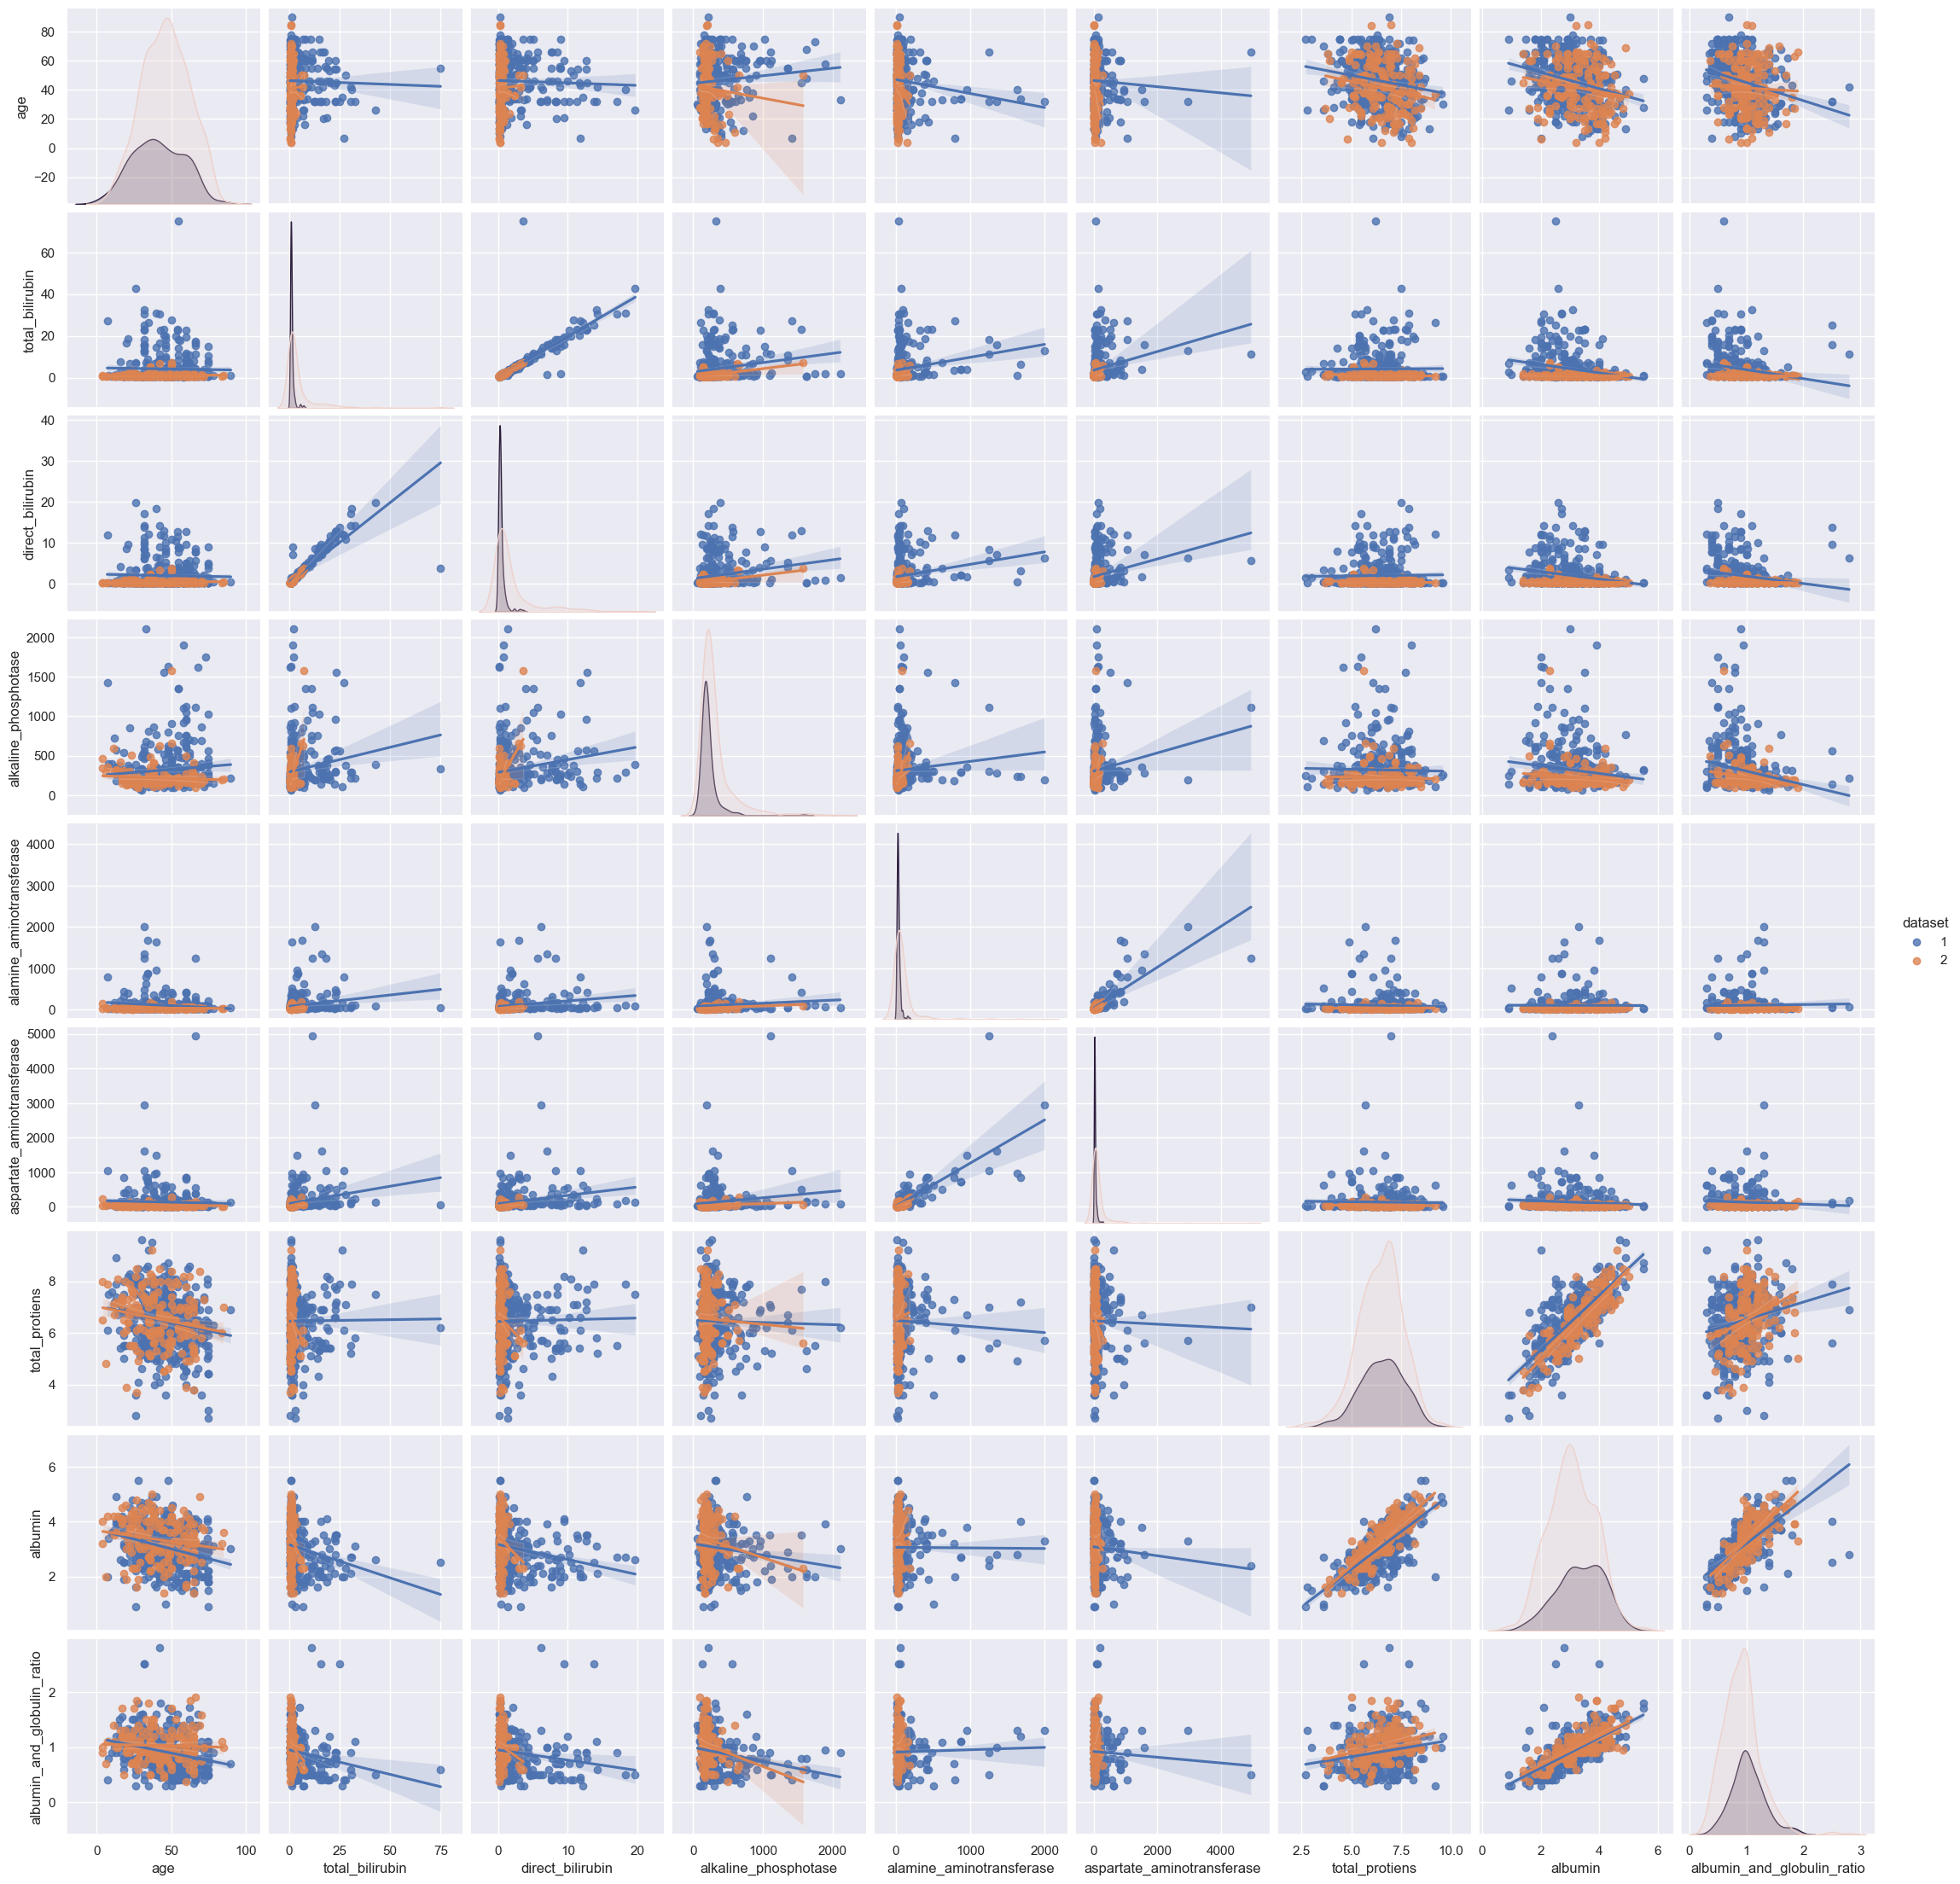

In [12]:
# correlation between variables
sns.set()
sns.pairplot(df, hue='dataset', kind='reg')

.

In [14]:
# this is simply my selection (from highly correlated features, you could also use different from pairs)
df.drop(['direct_bilirubin', 'aspartate_aminotransferase', 'total_protiens', 'albumin'], axis=1, inplace=True)

### Outliers & transformation
Now check data using boxplot and distplot to see what features are skewed, what is ratio of outliers, if log1p helps etc

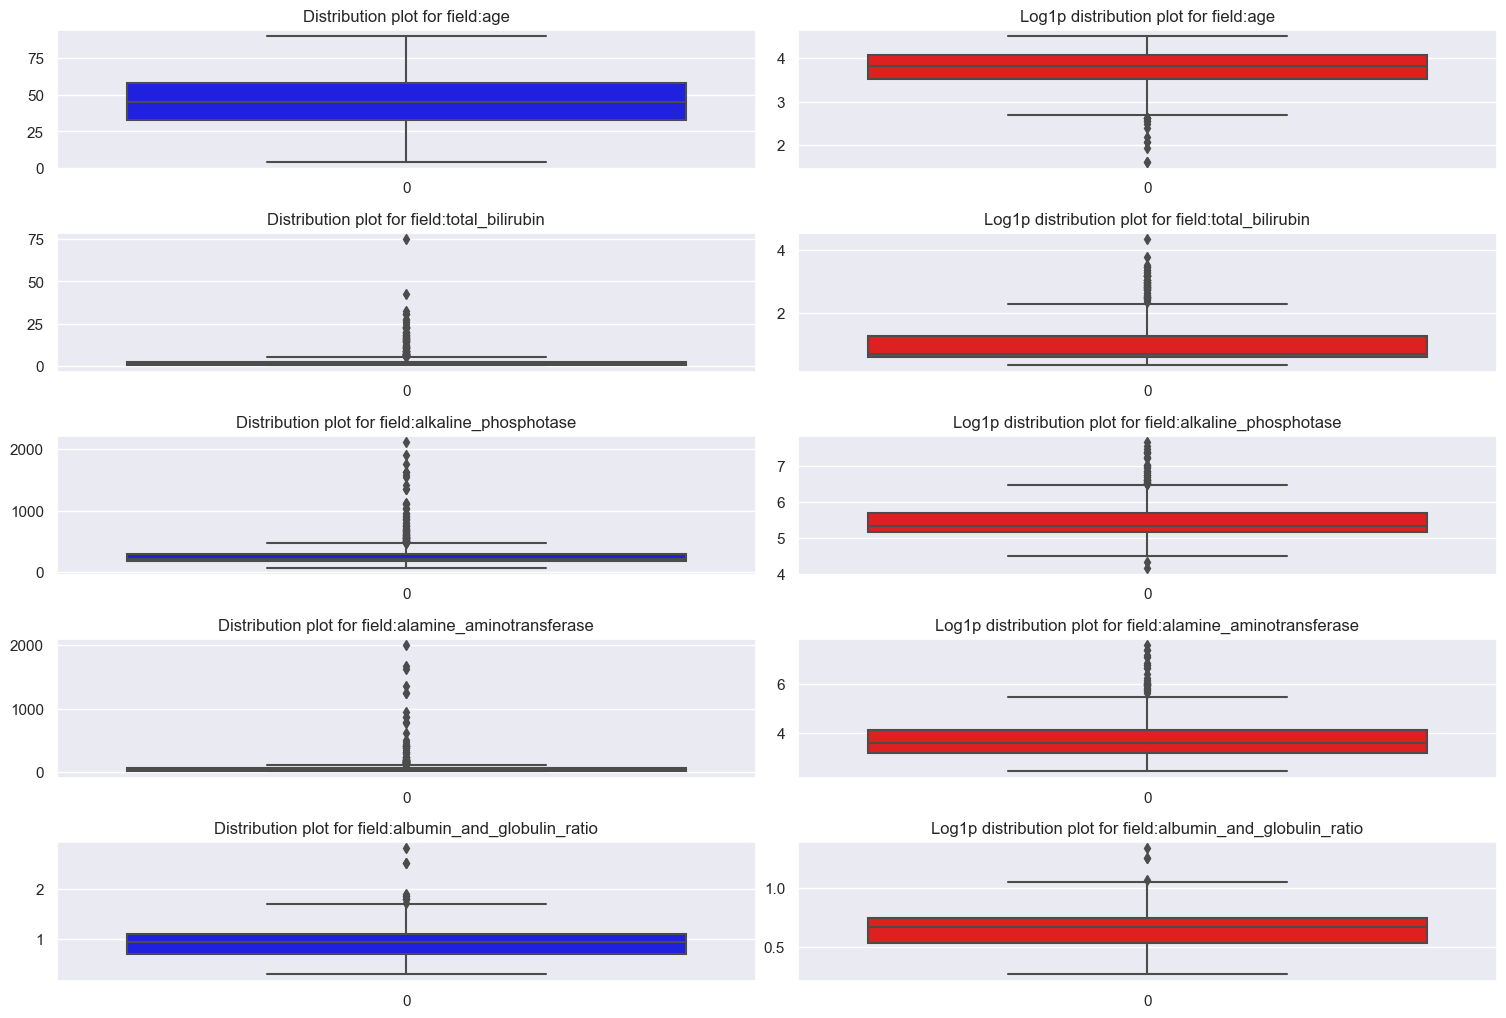

In [15]:
# outlier check
plt.figure(figsize=(15, 20))

for i, c in enumerate(df.drop('dataset', axis=1).select_dtypes(include='number').columns):
    plt.subplot(10,2,i*2+1)
    sns.boxplot(df[c], color='blue')
    plt.title('Distribution plot for field:' + c)
    plt.xlabel('')
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

    
    plt.subplot(10,2,i*2+2)
    sns.boxplot(df[c].apply('log1p'), color='red')
    plt.title('Log1p distribution plot for field:' + c)
    plt.xlabel('')
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

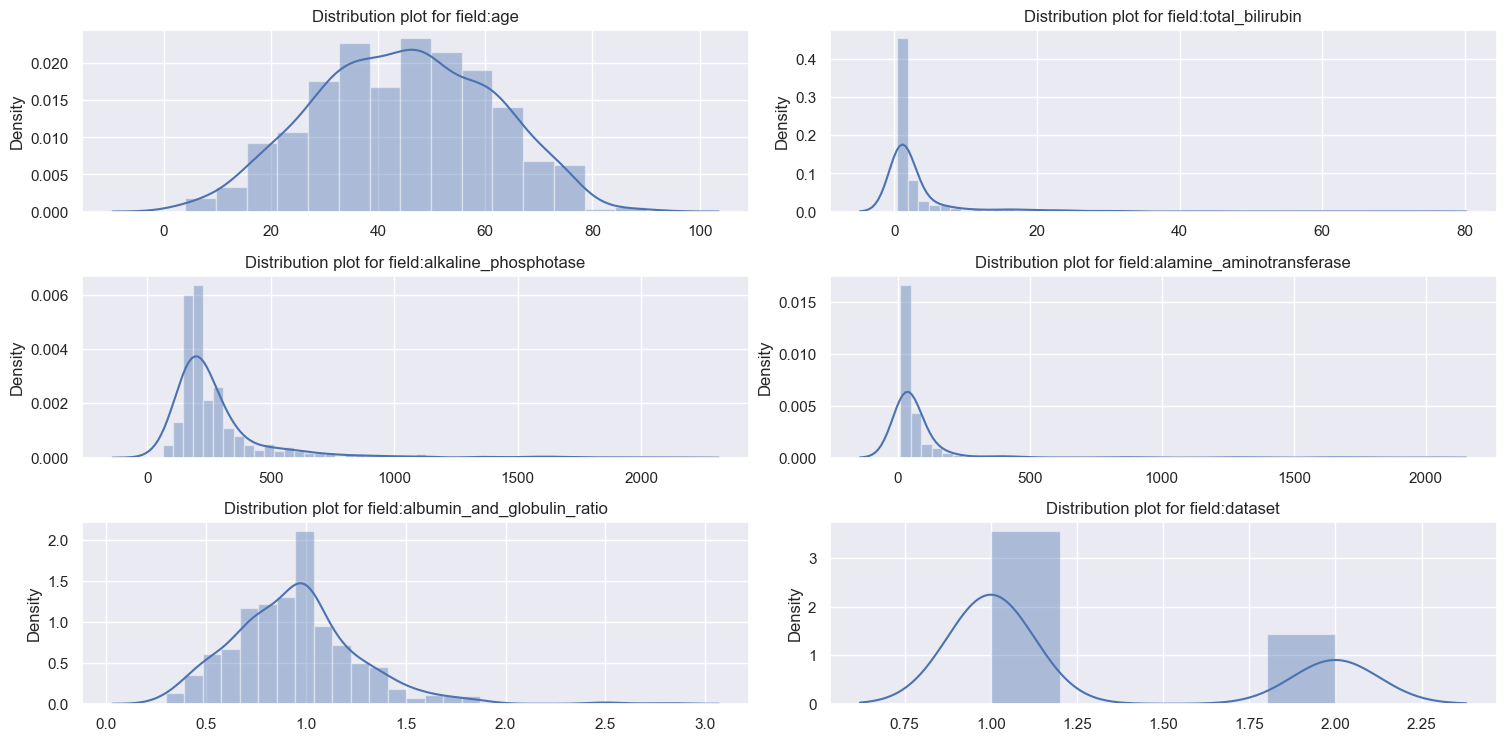

In [16]:
plt.figure(figsize=(15, 12))

for i, c in enumerate(df.select_dtypes(include='number').columns):
    plt.subplot(5,2,i+1)
    sns.distplot(df[c])
    plt.title('Distribution plot for field:' + c)
    plt.xlabel('')
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)


#### What can we get out of dist plot and box plot?
- dataset is slightly imbalanced
- slightly skewed features: albumin_and_globulin_ration
- strongly skewed features: total_bilirubin, direct_bilirubin, alkaline_phosphotase, alamine_aminotransferase, aspartate_aminotransferase

We will fix these values using log1p transformation and then scale variables using RobustScaler as this one is good for data with outliers. If you think this is not good procedure, let me know!

In [17]:
# save skewed features
skewed_cols = ['albumin_and_globulin_ratio','total_bilirubin', 'alkaline_phosphotase', 'alamine_aminotransferase']

In [18]:
# Apply log1p transformation on dataframe - just selected values
for c in skewed_cols:
    df[c] = df[c].apply('log1p')

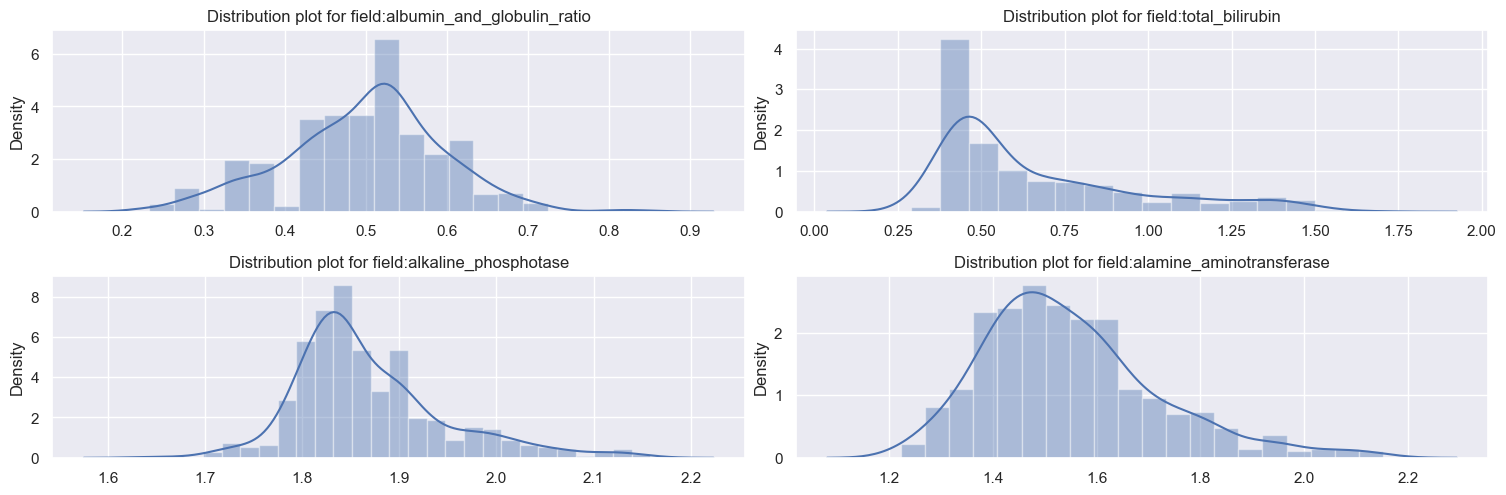

In [19]:
# Next check & fix strongly skewed features
# apply log1p transform
plt.figure(figsize=(15, 12))

for i, c in enumerate(skewed_cols):
    plt.subplot(5,2,i+1)
    sns.distplot(df[c].apply(np.log1p))
    plt.title('Distribution plot for field:' + c)
    plt.xlabel('')
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

## Encode & Scale
I will use sklearn library to encode gender and scale numerical variables

In [20]:
from sklearn.preprocessing import LabelEncoder, RobustScaler

In [21]:
# gender contains string values Male, Female; these will be converted into 0, 1, as ML algorithms like just numerical values
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])
df.gender.head()

0    0
1    1
2    1
3    1
4    1
Name: gender, dtype: int32

In [22]:
rs = RobustScaler()
for c in df[['age', 'gender', 'total_bilirubin', 'alkaline_phosphotase', 'alamine_aminotransferase', 'albumin_and_globulin_ratio']].columns:
    df[c] = rs.fit_transform(df[c].values.reshape(-1, 1))
df.head()

,age,gender,total_bilirubin,alkaline_phosphotase,alamine_aminotransferase,albumin_and_globulin_ratio,dataset
0,0.80,-1.0,-0.234465,-0.200886,-0.797391,-0.115796,1
1,0.68,0.0,2.572890,2.293084,0.627949,-0.532099,1
2,0.68,0.0,2.053111,1.620312,0.560449,-0.140769,1
3,0.52,0.0,0.000000,-0.252023,-0.930409,0.126945,1
4,1.08,0.0,1.292782,-0.121830,-0.267086,-1.560985,1


## Balance data
As our dataset is imbalanced, will use sklearn's sample to have same ratio of target variables (we could use also SMOTE from imblearn).
This may not be needed each time as some algorithms already have techniques for imbalanced datasets

In [23]:
from sklearn.utils import resample
df.dataset.value_counts()

dataset
1    416
2    167
Name: count, dtype: int64

In [24]:
# Split data on majority and minority.. minority is dataset == 2
minority = df[df.dataset==2]
majority = df[df.dataset==1]

print('Minority size:', minority.shape)
print('Majority size:', majority.shape)

Minority size: (167, 7)
Majority size: (416, 7)


In [25]:
# choosing upsample as even now we do not have too much data
minority_upsample = resample(minority, replace=True, n_samples=majority.shape[0])
print('Minority upsampled size:', minority_upsample.shape)

Minority upsampled size: (416, 7)


In [26]:
# merge majority with upsampled minority
df = pd.concat([minority_upsample, majority], axis=0)

## Split data for modeling
This is very needed in order to be able to compare performance of model on unseen data. I will choose test size to be 0.25. Dataset is also split to X (features) and y (target) variables.

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop('dataset', axis=1), df['dataset'], test_size=0.25, random_state=123)

print('Train values shape:', X_train.shape)
print('Test values shape:', X_test.shape)
print('Train target shape:', y_train.shape)
print('Test target shape:', y_test.shape)

Train values shape: (624, 6)
Test values shape: (208, 6)
Train target shape: (624,)
Test target shape: (208,)


## Model selection
We will use several popular models and see how they perform on our dataset.
At the end we choose 3 best performing models and will merge them together.

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [29]:
# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_train_hat = lr.predict(X_train)
y_test_hat = lr.predict(X_test)

print(lr)
print('Train performance')

print(classification_report(y_train, y_train_hat))

print('Test performance')

print(classification_report(y_test, y_test_hat))

print('Roc_auc score')

print(roc_auc_score(y_test, y_test_hat))
print('')

print('Confusion matrix')

print(confusion_matrix(y_test, y_test_hat))


LogisticRegression()
Train performance
              precision    recall  f1-score   support

           1       0.76      0.62      0.68       313
           2       0.68      0.81      0.74       311

    accuracy                           0.71       624
   macro avg       0.72      0.71      0.71       624
weighted avg       0.72      0.71      0.71       624

Test performance
              precision    recall  f1-score   support

           1       0.67      0.46      0.54       103
           2       0.59      0.78      0.67       105

    accuracy                           0.62       208
   macro avg       0.63      0.62      0.61       208
weighted avg       0.63      0.62      0.61       208

Roc_auc score
0.6186315302820157

Confusion matrix
[[47 56]
 [23 82]]


In [30]:
# Support Vector Machines
svm = SVC()
svm.fit(X_train, y_train)
y_train_hat = svm.predict(X_train)
y_test_hat = svm.predict(X_test)

print(svm)
print('Train performance')
print(classification_report(y_train, y_train_hat))

print('Test performance')

print(classification_report(y_test, y_test_hat))

print('Roc_auc score')

print(roc_auc_score(y_test, y_test_hat))
print('')

print('Confusion matrix')

print(confusion_matrix(y_test, y_test_hat))


SVC()
Train performance
              precision    recall  f1-score   support

           1       0.85      0.63      0.72       313
           2       0.70      0.88      0.78       311

    accuracy                           0.76       624
   macro avg       0.77      0.76      0.75       624
weighted avg       0.77      0.76      0.75       624

Test performance
              precision    recall  f1-score   support

           1       0.68      0.42      0.52       103
           2       0.59      0.81      0.68       105

    accuracy                           0.62       208
   macro avg       0.63      0.61      0.60       208
weighted avg       0.63      0.62      0.60       208

Roc_auc score
0.6134997688395747

Confusion matrix
[[43 60]
 [20 85]]


In [31]:
# Random Forest
rf = RandomForestClassifier(n_jobs=-1,random_state=123)
rf.fit(X_train, y_train)
y_train_hat = rf.predict(X_train)
y_test_hat = rf.predict(X_test)

print(rf)
print('Train performance')

print(classification_report(y_train, y_train_hat))

print('Test performance')

print(classification_report(y_test, y_test_hat))

print('Roc_auc score')

print(roc_auc_score(y_test, y_test_hat))
print('')

print('Confusion matrix')

print(confusion_matrix(y_test, y_test_hat))


RandomForestClassifier(n_jobs=-1, random_state=123)
Train performance
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       313
           2       1.00      1.00      1.00       311

    accuracy                           1.00       624
   macro avg       1.00      1.00      1.00       624
weighted avg       1.00      1.00      1.00       624

Test performance
              precision    recall  f1-score   support

           1       0.92      0.75      0.82       103
           2       0.79      0.93      0.86       105

    accuracy                           0.84       208
   macro avg       0.85      0.84      0.84       208
weighted avg       0.85      0.84      0.84       208

Roc_auc score
0.840453074433657

Confusion matrix
[[77 26]
 [ 7 98]]


In [32]:
# Neural nets
mlp = MLPClassifier()
mlp.fit(X_train, y_train)
y_train_hat = mlp.predict(X_train)
y_test_hat = mlp.predict(X_test)

print(mlp)
print('Train performance')

print(classification_report(y_train, y_train_hat))

print('Test performance')

print(classification_report(y_test, y_test_hat))

print('Roc_auc score')

print(roc_auc_score(y_test, y_test_hat))
print('')

print('Confusion matrix')

print(confusion_matrix(y_test, y_test_hat))


MLPClassifier()
Train performance
              precision    recall  f1-score   support

           1       0.79      0.68      0.73       313
           2       0.72      0.82      0.77       311

    accuracy                           0.75       624
   macro avg       0.76      0.75      0.75       624
weighted avg       0.76      0.75      0.75       624

Test performance
              precision    recall  f1-score   support

           1       0.71      0.54      0.62       103
           2       0.64      0.78      0.70       105

    accuracy                           0.66       208
   macro avg       0.67      0.66      0.66       208
weighted avg       0.67      0.66      0.66       208

Roc_auc score
0.6623208506703652

Confusion matrix
[[56 47]
 [23 82]]


Not so good as random forest

In [33]:
# K-Neighbors
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_train_hat = knn.predict(X_train)
y_test_hat = knn.predict(X_test)
print(knn)
print('Train performance')

print(classification_report(y_train, y_train_hat))

print('Test performance')

print(classification_report(y_test, y_test_hat))

print('Roc_auc score')

print(roc_auc_score(y_test, y_test_hat))
print('')

print('Confusion matrix')

print(confusion_matrix(y_test, y_test_hat))


KNeighborsClassifier()
Train performance
              precision    recall  f1-score   support

           1       0.86      0.75      0.80       313
           2       0.78      0.87      0.82       311

    accuracy                           0.81       624
   macro avg       0.82      0.81      0.81       624
weighted avg       0.82      0.81      0.81       624

Test performance
              precision    recall  f1-score   support

           1       0.70      0.58      0.63       103
           2       0.65      0.75      0.70       105

    accuracy                           0.67       208
   macro avg       0.67      0.67      0.67       208
weighted avg       0.67      0.67      0.67       208

Roc_auc score
0.6674526121128063

Confusion matrix
[[60 43]
 [26 79]]


Also not so good

c

In [34]:
import numpy as np

unique_classes = np.unique(y_train)
print("Unique classes in y_train:", unique_classes)

y_train_binary = y_train - 1  
y_test_binary = y_test - 1    


from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=123)
xgb.fit(X_train, y_train_binary)
y_train_hat = xgb.predict(X_train)
y_test_hat = xgb.predict(X_test)


Unique classes in y_train: [1 2]


In [35]:
print(xgb)
print('Train performance')

print(classification_report(y_train, y_train_hat))

print('Test performance')

print(classification_report(y_test, y_test_hat))

print('Roc_auc score')

print(roc_auc_score(y_test, y_test_hat))
print('')

print('Confusion matrix')

print(confusion_matrix(y_test, y_test_hat))


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=123, ...)
Train performance
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00     313.0
           2       0.00      0.00      0.00     311.0

    acc

Nice one, XGBoost is catching random forest in performance!

In [36]:
# Extra Trees
from sklearn.ensemble import ExtraTreesClassifier

etc = ExtraTreesClassifier(random_state=123)
etc.fit(X_train, y_train)
y_train_hat = etc.predict(X_train)
y_test_hat = etc.predict(X_test)

print(etc)
print('Train performance')

print(classification_report(y_train, y_train_hat))

print('Test performance')

print(classification_report(y_test, y_test_hat))

print('Roc_auc score')

print(roc_auc_score(y_test, y_test_hat))
print('')

print('Confusion matrix')

print(confusion_matrix(y_test, y_test_hat))



ExtraTreesClassifier(random_state=123)
Train performance
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       313
           2       1.00      1.00      1.00       311

    accuracy                           1.00       624
   macro avg       1.00      1.00      1.00       624
weighted avg       1.00      1.00      1.00       624

Test performance
              precision    recall  f1-score   support

           1       0.87      0.82      0.84       103
           2       0.83      0.88      0.85       105

    accuracy                           0.85       208
   macro avg       0.85      0.85      0.85       208
weighted avg       0.85      0.85      0.85       208

Roc_auc score
0.8458622283865003

Confusion matrix
[[84 19]
 [13 92]]


Incredible! Extra Trees has definitely best performance from all models we've tried:
- 86% precission
- 86% recall
- 0.86 f1
- 0.85 roc_auc

## Model evaluation & optimization
As our dataset is not too big, we will use GridSearchCV for parameter tuning, in case of large datasets RandomizedSearchCV could be better. Our main objective will be to improve roc_auc score and avoid overfitting

In [37]:
from sklearn.model_selection import GridSearchCV, KFold

In [38]:
# Random forest

params = {
    'n_estimators': [100, 200, 500],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [1,2,4,5],
    'min_samples_leaf': [1,2,4,5],
    'max_leaf_nodes': [4,10,20,50,None]
}

gs1 = GridSearchCV(RandomForestClassifier(n_jobs=-1), params, n_jobs=-1, cv=KFold(n_splits=3), scoring='roc_auc')
gs1.fit(X_train, y_train)

print('Best score:', gs1.best_score_)
print('Best score:', gs1.best_params_)


Best score: 0.9130856527906036
Best score: {'criterion': 'entropy', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [40]:
# Extra Tree

params = {
    'n_estimators': [100, 200, 500],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [1,2,4,5],
    'min_samples_leaf': [1,2,4,5],
    'max_leaf_nodes': [4,10,20,50,None]
}

gs3 = GridSearchCV(ExtraTreesClassifier(n_jobs=-1), params, n_jobs=-1, cv=KFold(n_splits=3), scoring='roc_auc')
gs3.fit(X_train, y_train)

print('Best score:', gs3.best_score_)
print('Best score:', gs3.best_params_)

Best score: 0.9315219513788108
Best score: {'criterion': 'entropy', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


.

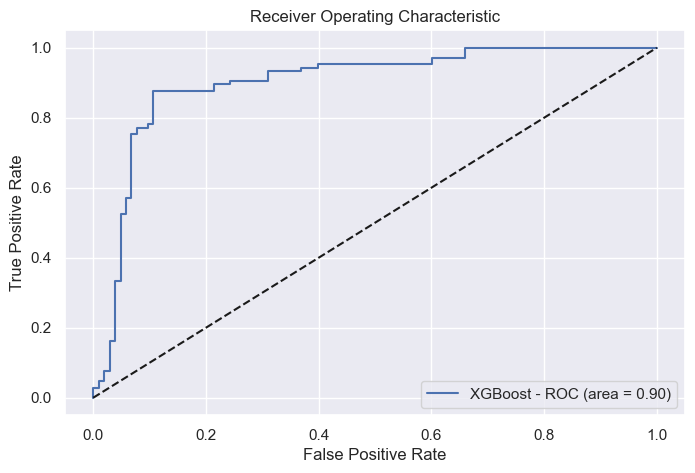

In [46]:
# Convert classes from [1, 2] to [0, 1]
y_train_binary = y_train - 1
y_test_binary = y_test - 1



# Fit the XGBoost classifier
xgb = XGBClassifier(random_state=123)
xgb.fit(X_train, y_train_binary)

# Make predictions
y_pred_proba = xgb.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC
fpr1, tpr1, thresholds = metrics.roc_curve(y_test_binary, y_pred_proba)
auc = metrics.roc_auc_score(y_test_binary, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 5))
plt.plot(fpr1, tpr1, label='XGBoost - ROC (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [51]:
from sklearn.metrics import accuracy_score

etc_acc = accuracy_score(y_test, etc.predict(X_test))

etc

ExtraTreesClassifier(random_state=123)

In [52]:
import pickle
model = etc_acc
pickle.dump(model, open("liver.pkl","wb"))